In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import os
from scipy.stats import entropy
from scipy.stats import mode
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint
from sklearn.metrics import accuracy_score, classification_report, f1_score
import statistics as st

from google.colab import files

from tqdm.auto import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder

from sklearn.ensemble import HistGradientBoostingClassifier

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#file = "/content/drive/MyDrive/PAMAP2_Dataset"

#df = pd.read_csv(file)
#df.head()

In [ ]:
directory = "/content/drive/MyDrive/PAMAP2_Dataset/Protocol" #'PAMAP2_Dataset\Protocol'
subj_dfs = pd.DataFrame()

for subj_num in range(101, 110):
    file_path = os.path.join(directory, f'subject{subj_num}.dat')
    subj = np.loadtxt(file_path)

    test_dict = {'user': np.repeat([subj_num % 100], len(subj)),
                'acc_x': subj[:, 4], 'acc_y': subj[:, 5], 'acc_z': subj[:, 6],
                'activity': subj[:, 1]}
    subj_df = pd.DataFrame(test_dict)
    subj_dfs = pd.concat([subj_dfs, subj_df], ignore_index=True)

In [ ]:
unique_users = [1, 2, 3, 4, 5, 6, 7, 8, 9] # hardcoded the num of datasets to do train/test split
train_users, test_users = train_test_split(unique_users, test_size=0.25, random_state=1)

train_df = subj_dfs[subj_dfs['user'].isin(train_users)]
test_df = subj_dfs[subj_dfs['user'].isin(test_users)]

In [ ]:
print(train_users)

train_df

In [ ]:
print(test_users)
test_df

In [ ]:
def statistical_features(segment):
    features = {}

    x = segment['acc_x'].values
    y = segment['acc_y'].values
    z = segment['acc_z'].values

    mag_x = np.sqrt(np.sum(x**2, axis = 0))
    mag_y = np.sqrt(np.sum(y**2, axis = 0))
    mag_z = np.sqrt(np.sum(z**2, axis = 0))

    # features
    # removed st.mode(x), y, z
    x_feat = [np.mean(x), np.median(x), np.var(x), np.max(x), np.min(x), np.mean(mag_x), np.max(mag_x), np.min(mag_x)]
    y_feat = [np.mean(y), np.median(y), np.var(y), np.max(y), np.min(y), np.mean(mag_y), np.max(mag_y), np.min(mag_y)]
    z_feat = [np.mean(z), np.median(z), np.var(z), np.max(z), np.min(z), np.mean(mag_z), np.max(mag_z), np.min(mag_z)]

    feat = np.array([x_feat, y_feat, z_feat]).flatten()
    #print(feat.shape[0])

    return feat

In [ ]:
def sliding_window(df, window_size, step_size):

    features = []
    majority_votes = []

    num_cols = 3 #len(df.columns) # should be 3

    #window = window_size * 3  # start with 50x3, window_size = 50
    print(len(df))
    print(step_size)

    count = 0
    for start in tqdm(range(0, len(df), step_size)):
        # if start % 15000 == 0:
        #   print(start)
        end = start + window_size # non overlapping
        segment = df[start:end]

        feature = statistical_features(segment[['acc_x', 'acc_y', 'acc_z']])
        features.append(feature)

        majority_votes.append(st.mode(segment['activity'].values))
        count += 1

    print('count: {}'.format(count))
    print('features shape: '.format(np.array(features).shape))
    print('majority votes shape: '.format(np.array(majority_votes).shape))
    return features, majority_votes

In [ ]:
train_df = train_df.dropna()
test_df = test_df.dropna()

In [ ]:
train_windows, train_labels = sliding_window(train_df, 100, 100)
test_windows, test_labels = sliding_window(test_df, 100, 100)

2286514
100


  0%|          | 0/22866 [00:00<?, ?it/s]

count: 22866
features shape: 
majority votes shape: 
572878
100


  0%|          | 0/5729 [00:00<?, ?it/s]

count: 5729
features shape: 
majority votes shape: 


In [ ]:
test_windows_df = pd.DataFrame(test_windows)
test_windows_df

In [ ]:
train_labels_df = pd.DataFrame(train_labels)
train_labels_df.value_counts()

In [ ]:
test_labels_df = pd.DataFrame(test_labels)
test_labels_df.value_counts()

In [ ]:
label_encoder = LabelEncoder().fit(train_labels)
old_labels = np.copy(train_labels)
train_labels = label_encoder.transform(train_labels)
test_labels = label_encoder.transform(test_labels)

Text(0.5, 1.0, 'after label encoding')

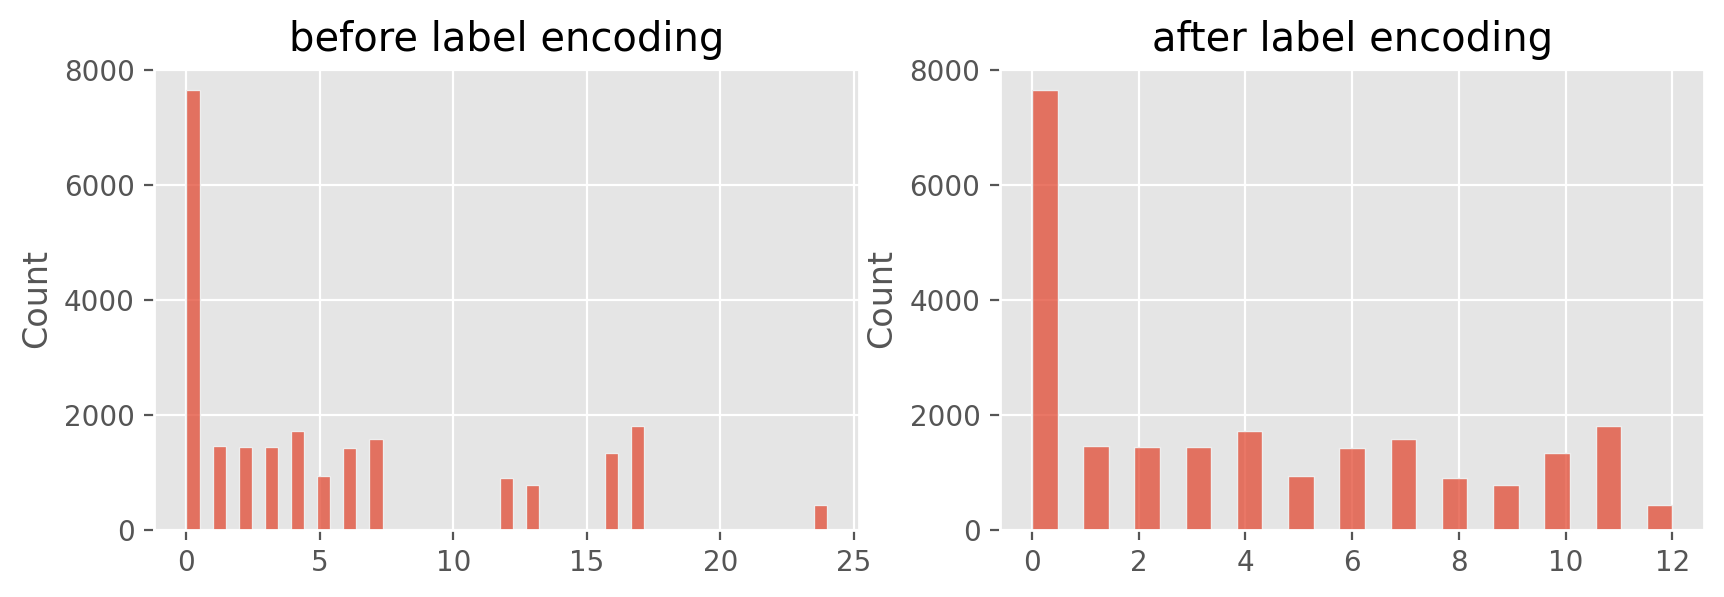

In [ ]:
plt.figure(dpi=200, figsize=(10, 3))
plt.style.use('ggplot')

plt.subplot(1, 2, 1)
sns.histplot(old_labels)
plt.title('before label encoding')

plt.subplot(1, 2, 2)
sns.histplot(train_labels) # was previously "new_labels"
plt.title('after label encoding')

Classification


In [ ]:
rf = RandomForestClassifier()
rf.fit(train_windows, train_labels)
test_predictions = rf.predict(test_windows)

# print(test_labels[0:100])
# print(test_predictions[0:100])
accuracy = accuracy_score(test_labels, test_predictions)
f1 = f1_score(test_labels, test_predictions, average='macro')
print("accuracy: ", accuracy)
print("F1 score: ", f1)

accuracy:  0.456973293768546
F1 score:  0.40718675009670263


In [ ]:
# clf = HistGradientBoostingClassifier().fit(train_windows, new_labels)
# test_predictions = clf.predict(test_windows)


In [ ]:
# rf = RandomForestClassifier()

# rf.fit(train_windows, train_labels)
# # test_predictions = rf.predict(test_labels)


# print(accuracy_score(test_windows, test_predictions))
# print(classification_report(test_windows, test_predictions))
# print((f1_score(test_windows, test_predictions, average='macro')))